### Import libaries

In [37]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image


import torch
import torchvision
import torch.nn as nn

from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms

from torch.utils.data import random_split
from torchvision.utils import make_grid

%matplotlib inline


### Import Data from kaggle

In [38]:
#install kaggle
!pip install -q kaggle

In [39]:
#Import kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"msrpavan","key":"2ffaf9cc7f9a6ba0387ba9d9b81bf16b"}'}

In [40]:
# Create kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [41]:
# Copy kaggle.json file to kaggle folder
! cp kaggle.json ~/.kaggle/

In [42]:
# Permissions Required
! chmod 600 ~/.kaggle/kaggle.json

In [43]:
#! kaggle datasets list

In [44]:
! kaggle datasets download dinodev/majorplantdiseasedetection

Dataset URL: https://www.kaggle.com/datasets/dinodev/majorplantdiseasedetection
License(s): unknown
majorplantdiseasedetection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [45]:
! unzip majorplantdiseasedetection.zip

Archive:  majorplantdiseasedetection.zip
replace dataset/test/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Set-up Device-Agnostic code

In [46]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Create Train and Test directories

In [60]:
data_dir="/content/dataset"
train_dir= data_dir+"/train"           #/content/dataset/train
test_dir=data_dir+"/test"

### Data Exploration

In [61]:
classes=os.listdir(train_dir)
print(classes)

['Apple___healthy', 'Strawberry___Leaf_scorch', 'Coffee__red spider mite', 'Peach___healthy', 'Cherry_(including_sour)___healthy', 'Chili__yellowish', 'Potato___Early_blight', 'Tomato___Late_blight', 'Coffee__healthy', 'Chili__healthy', 'Grape___Esca_(Black_Measles)', 'Tomato___Early_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Grape___Black_rot', 'Potato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Bacterial_spot', 'Peach___Bacterial_spot', 'Tomato___Leaf_Mold', 'Grape___healthy', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Tomato_mosaic_virus', 'Coffee__Rust', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Apple___Apple_scab', 'Potato___healthy', 'Strawberry___healthy', 'Tomato___Septoria_leaf_spot', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Pepper,_bell___Bacterial_spot', 'Apple___Black_rot', 'Pepper,_bell___healthy', 'Chili__leaf curl', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Chili__lea

In [62]:
print(f"Total disease classes are: {len(classes)}")

Total disease classes are: 41


In [63]:
plants=[]
num_of_Diseases=0
for cls in classes:
  if cls.split('__')[0] not in plants:
    plants.append(cls.split('__')[0])
  if cls.split('__')[1] !='healthy':
    num_of_Diseases +=1

print("Unique Plants :\n",plants)
print("Number of unique Plants :\n",len(plants))
print("Number of Diseases :\n",num_of_Diseases)

Unique Plants :
 ['Apple', 'Strawberry', 'Coffee', 'Peach', 'Cherry_(including_sour)', 'Chili', 'Potato', 'Tomato', 'Grape', 'Corn_(maize)', 'Pepper,_bell']
Number of unique Plants :
 11
Number of Diseases :
 39


In [64]:
num_of_images_per_class={}
for cls in classes:
  num_of_images_per_class[cls]=len(os.listdir(train_dir + '/' + cls))

img_per_class=pd.DataFrame(num_of_images_per_class.values() ,
                           num_of_images_per_class.keys() ,
                           columns=['No.of Images'])
img_per_class

,No.of Images
Apple___healthy,1316
Strawberry___Leaf_scorch,888
Coffee__red spider mite,136
Peach___healthy,288
Cherry_(including_sour)___healthy,684
Chili__yellowish,80
Potato___Early_blight,800
Tomato___Late_blight,1528
Coffee__healthy,282
Chili__healthy,80


#### Transformimg Data to Pytorch DataSets

In [102]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
])

In [103]:
train_dataset=ImageFolder(train_dir,transform=transform)
test_dataset=ImageFolder(test_dir,transform=transform)

In [104]:
class_names = train_dataset.classes
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Cherry_(including_sour)___Powdery_mildew',
 'Cherry_(including_sour)___healthy',
 'Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish',
 'Coffee__Rust',
 'Coffee__healthy',
 'Coffee__red spider mite',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___S

In [105]:
class_dict = train_dataset.class_to_idx
class_dict

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Cherry_(including_sour)___Powdery_mildew': 4,
 'Cherry_(including_sour)___healthy': 5,
 'Chili__healthy': 6,
 'Chili__leaf curl': 7,
 'Chili__leaf spot': 8,
 'Chili__whitefly': 9,
 'Chili__yellowish': 10,
 'Coffee__Rust': 11,
 'Coffee__healthy': 12,
 'Coffee__red spider mite': 13,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 14,
 'Corn_(maize)___Common_rust_': 15,
 'Corn_(maize)___Northern_Leaf_Blight': 16,
 'Corn_(maize)___healthy': 17,
 'Grape___Black_rot': 18,
 'Grape___Esca_(Black_Measles)': 19,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 20,
 'Grape___healthy': 21,
 'Peach___Bacterial_spot': 22,
 'Peach___healthy': 23,
 'Pepper,_bell___Bacterial_spot': 24,
 'Pepper,_bell___healthy': 25,
 'Potato___Early_blight': 26,
 'Potato___Late_blight': 27,
 'Potato___healthy': 28,
 'Strawberry___Leaf_scorch': 29,
 'Strawberry___healthy': 30,
 'Tomato___Bacterial_spot': 31,


In [106]:
len(train_dataset)  , len(test_dataset)

(33111, 8339)

In [107]:
img , label =train_dataset[0]
print("The Shape of Image : ", img.shape)
print("Class of image : " , class_names[label])
print(f"Image Label : {label}")
print(f"Image Data type : {img.dtype}")
print(f"Label Data type : {type(label)}")

The Shape of Image :  torch.Size([3, 64, 64])
Class of image :  Apple___Apple_scab
Image Label : 0
Image Data type : torch.float32
Label Data type : <class 'int'>


#### Visulaize images

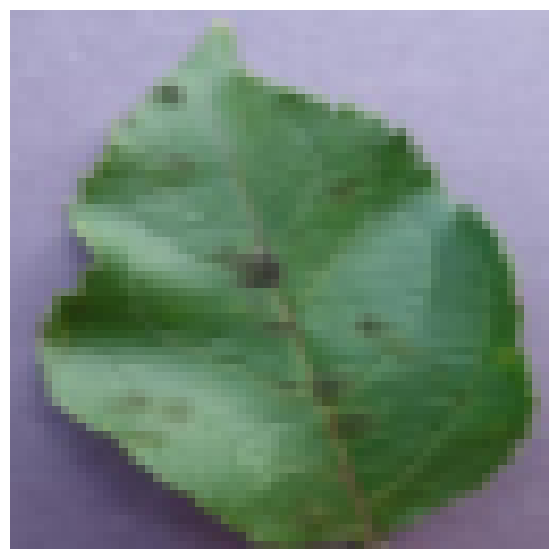

In [108]:
per_img = img.permute(1,2,0)
plt.figure(figsize=(7,7))
plt.imshow(per_img)
plt.axis("off")
plt.show()

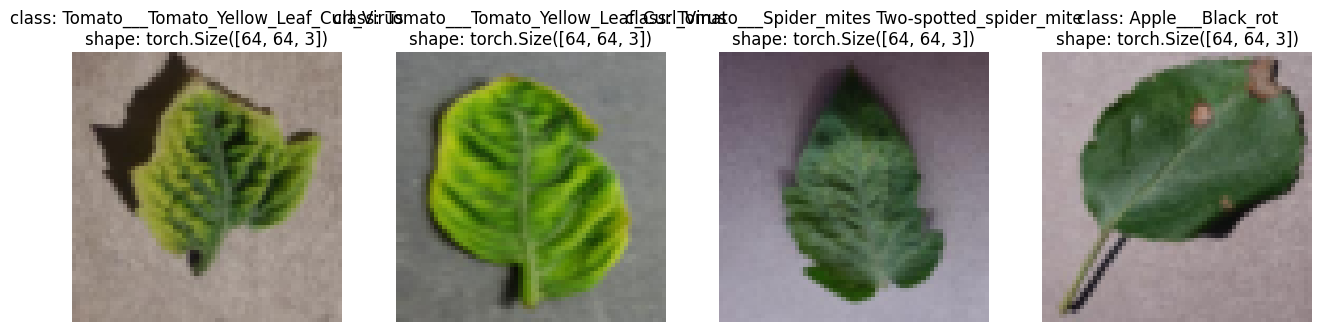

In [109]:
from typing import Tuple, Dict, List
import random

def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print("Please Enter Number less than 10")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

# Display random images from ImageFolder created Dataset
display_random_images(train_dataset,
                      n=4,
                      classes=class_names,
                      seed=None)

#### Tranform Data to DataLoader

In [110]:
Batch_size=16
num_workers=os.cpu_count()

In [111]:
train_dataloader = DataLoader(train_dataset , batch_size=Batch_size ,
                              num_workers=num_workers , shuffle=True)
test_dataloader = DataLoader(test_dataset , batch_size=Batch_size ,
                              num_workers=num_workers , shuffle=False)

#### Visualize Images

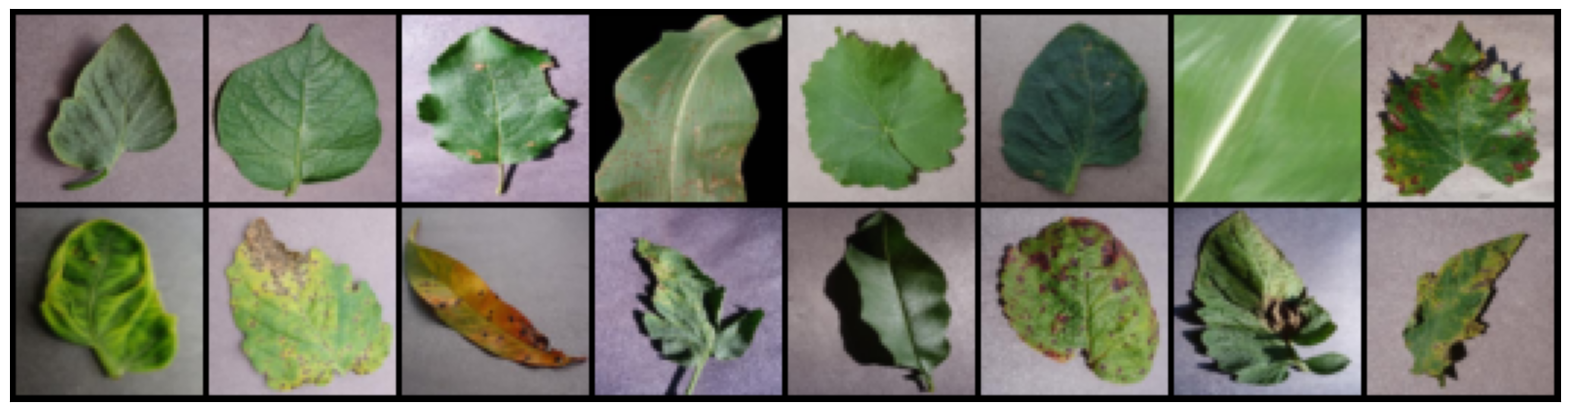

In [112]:
def show_images(dataloader):
  for images , labels in dataloader:
    fig ,ax = plt.subplots(figsize=(20,20))
    ax.set_xticks([]) , ax.set_yticks([])
    ax.imshow(make_grid(images , nrow=8).permute(1,2,0))
    break

show_images(train_dataloader)

### Model

In [114]:
# Create a function to create Resenet Block
def conv_block(in_channels , out_channels , pool=False):
  layer = [
      nn.Conv2d(in_channels , out_channels , kernel_size=5 , padding=2),
      nn.BatchNorm2d(out_channels),
      nn.ReLU(inplace=True)

  ]
  if pool:
    layer.append(nn.MaxPool2d(2))

  return nn.Sequential(*layer)


# Architecture of Model
class ResNet9(nn.Module):
  def __init__(self , in_channels , num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channels , 64 )
    self.conv2 = conv_block(64 , 128, pool=True)
    self.resn1 = nn.Sequential(conv_block(128,128), conv_block(128,128))

    self.conv3 = conv_block(128 , 256, pool=True)
    self.conv4 = conv_block(256 , 512, pool=True)
    self.resn2 = nn.Sequential(conv_block(512,512), conv_block(512,512))

    self.classifier = nn.Sequential(nn.MaxPool2d(5),
                                    nn.Flatten(),
                                    nn.Linear(512 , num_classes))

  def forward(self ,x):

    out = self.conv1(x)
    out = self.conv2(out)
    out = self.resn1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.resn2(out) + out

    out = self.classifier(out)

    return out

model = ResNet9(3 , len(class_names)).to(device)


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

#### Info on Model

In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo

import torchinfo
from torchinfo import summary

summary(model, input_size=(16, 3, 64, 64))

#### Train Model

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fxn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device,
               ):
  # Set model in Train Mode
  model.train()

  # Define Train and Train Accuracy
  train_loss,train_acc= 0,0

  # Loop through data loader data batches
  for batch, (X,y) in enumerate(dataloader):
    X=X.to(device)
    y=y.to(device)

    # Forward Pass
    y_pred=model(X)  # We get Logits
    loss=loss_fxn(y_pred,y)
    train_loss+=loss.item()

    # Optimizer to zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    #Optimizer Step
    optimizer.step()

    # Cal. Accuracy
    y_pred_class= torch.argmax(torch.softmax(y_pred,dim=1),dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

# Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model:torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fxn:torch.nn.Module,
              device=device,
              ):
  # Set model in Eval Mode
  model.eval()
  test_loss,test_acc=0,0

  # Turn on inference mode
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X=X.to(device)
      y=y.to(device)
      # Forward Pass
      y_test_pred=model(X)
      # Cal. Loss
      loss=loss_fxn(y_test_pred,y)
      test_loss += loss.item()
      # Cal. Accuracy
      y_pred_class=torch.argmax(torch.softmax(y_test_pred,dim=1),dim=1)
      test_acc += (y_pred_class ==y).sum().item()/len(y_test_pred)

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fxn: torch.nn.Module,
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fxn=loss_fxn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fxn=loss_fxn)

        # 4. Print out what's happening
        if epoch % 5 ==0:
          print(
              f"Epoch: {epoch} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}"
          )
        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set No.of Epochs
NUM_EPOCHS=10
# Loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set Timer
from timeit import default_timer as timer
start_time=timer()

# Train
model_results= train(model=model,
                     train_dataloader=train_dataloader,
                     test_dataloader=test_dataloader,
                     optimizer=optimizer,
                     loss_fxn=loss,
                     epochs=NUM_EPOCHS
                     )
# End Timer()
end_time=timer()
print(f"Total Time {end_time-start_time:.3f} seconds")